In [1]:
# load libraies

%run py_libraries.py

/Users/4476224/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.13.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# loading utility files

from utility.sv_fig import savefig
from utility.make_cm import make_confusion_matrix
from utility.get_g_result import get_gamma_results
from utility.plt_result import plot_results

In [3]:
def savefig(filename, crop = True):
    plt.savefig('{}.pdf'.format(filename))

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

# load data
X_train = pd.read_csv('data/norm_X_train_PCa_NCa.csv')
X_test = pd.read_csv('data/norm_X_test_PCa_NCa.csv')
y_train = pd.read_csv('data/y_train_PCa_NCa.csv')
y_test = pd.read_csv('data/y_test_PCa_NCa.csv')


print(X_train.shape)

(56, 26)


In [5]:
# visualize confusion matrix with seaborn heatmap

def my_cm(c_matrix):
    labels = ['TP','FN','FP','TN']
    categories = ['PCa', 'NCa']
    make_confusion_matrix(c_matrix,
                          group_names=labels,
                          categories=categories,
                          cmap='Blues')

In [6]:
# run_it_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics = 'Kappa'):

def run_it_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics):
    # Optmize the decision threshold based on the Cohen's Kappa coefficient
    if ThOpt_metrics == 'Kappa':
        tscores = []
        # evaluate the score on the oob using different thresholds
        for thresh in thresholds:
            scores = [1 if x>=thresh else -1 for x in oob_probs]
            kappa = metrics.cohen_kappa_score(labels_train,scores)
            tscores.append((np.round(kappa,3),thresh))
        # select the threshold providing the highest kappa score as optimal
        tscores.sort(reverse=True)
        imb_mcc_kap = tscores[0][0]
        thresh = tscores[0][-1]
    # Optmize the decision threshold based on the MCC
    elif ThOpt_metrics == 'MCC':
        tscores = []
        # evaluate the score on the oob using different thresholds
        for thresh in thresholds:
            scores = [1 if x>=thresh else -1 for x in oob_probs]
            mcc = metrics.matthews_corrcoef(labels_train,scores)
            tscores.append((np.round(mcc,3),thresh))
        # select the threshold providing the highest mcc score as optimal
        tscores.sort(reverse=True)
        imb_mcc_kap = tscores[0][0]
        thresh = tscores[0][-1]
    
    return imb_mcc_kap, thresh

In [7]:
from sklearn import metrics
import numpy as np

def calc_metrics(labels_test, test_probs, threshold, ThOpt_metrics):
    if ThOpt_metrics == 'Kappa':
        scores = [1 if x>=threshold else -1 for x in test_probs]
        auc = metrics.roc_auc_score(labels_test, test_probs)
        kappa = metrics.cohen_kappa_score(labels_test,scores)
        confusion = metrics.confusion_matrix(labels_test,scores, labels=list(set(labels_test)))
        print('thresh: %.4f, kappa: %.4f, AUC test-set: %.4f'%(threshold, kappa, auc))
        print(confusion)
        print(metrics.classification_report(labels_test,scores))
    elif ThOpt_metrics == 'MCC':
        scores = [1 if x>=threshold else -1 for x in test_probs]
        auc = metrics.roc_auc_score(labels_test, test_probs)
        mcc = metrics.matthews_corrcoef(labels_test,scores)
        confusion = metrics.confusion_matrix(labels_test,scores, labels=list(set(labels_test)))
        print('thresh: %.4f, mcc: %.4f, AUC test-set: %.4f'%(threshold, mcc, auc))
        print(confusion)
        print(metrics.classification_report(labels_test,scores))
    return confusion

In [8]:
def best_param_svm_search(X_train,y_train,n_splits,hyper_params,Cs,gammas,filename1,filename2,kl,rnd_st):
    
    # creating a KFold object with n splits
    folds = KFold(n_splits = n_splits, shuffle = True, random_state = rnd_st)
    model = SVC(kernel=kl)  # specify model
    
    # set up GridSearchCV()
    model_cv = GridSearchCV(estimator = model, param_grid = hyper_params, \
                        scoring= 'accuracy', cv = folds, verbose = 1,\
                        return_train_score=True, n_jobs = -1)
    # fit the model
    model_cv.fit(X_train, y_train)
    
    # obtaining the optimal accuracy score and hyperparameters
    best_score = model_cv.best_score_
    best_hyperparams = model_cv.best_params_
    
    best_C = best_hyperparams['C']
    best_gamma = best_hyperparams['gamma']
    
    cv_res = pd.DataFrame(model_cv.cv_results_)
    cv_res[["param_C", "param_gamma"]] = cv_res[["param_C", "param_gamma"]].astype(np.float64)
    
    # reshape values into a matrix with 'X' and 'Y' grid equals 'C' and 'gamma' respt
    test_scores_matrix = cv_res.pivot(
        index="param_gamma", columns="param_C", values="mean_test_score")
    
    train_scores_matrix = cv_res.pivot(
        index="param_gamma", columns="param_C", values="mean_train_score")
    
    # # values corresponding to 'best_C' and 'best_gamma' 
    # z1 = test_scores_matrix.loc[best_C,best_gamma]   # this line may be buggy
    # z2 = train_scores_matrix.loc[best_C,best_gamma]  # this line may be buggy
    
    ###########################################################################################
    
    
    fig1, (ax1, ax2) = plt.subplots(figsize=(13, 4), ncols=2)
    
    # plot imshow test accuracy
    Z1 = test_scores_matrix
    im1 = ax1.imshow(Z1, interpolation='none', cmap=cm.coolwarm,
                   origin='lower', extent=[Cs[0], Cs[-1], gammas[0], gammas[-1]], aspect=6)  # cmap='seismic', cmap=cm.coolwarm
    ax1.plot(best_C, best_gamma, marker='*', color="black")
    ax1.annotate(
        f'best param \n ({best_C:.3f}, {best_gamma:.3f})',
        xy=(best_C, best_gamma),
        xytext=(best_C+0.2, best_gamma+0.03),
        arrowprops=None, fontsize=10)
    ax1.set_xlabel("C", fontsize=15)
    ax1.set_ylabel(r'$\gamma$', fontsize=15)
    ax1.set_title("Test Accuracy \n Kernel = {} \n cv = {:d}".format(kl,n_splits), fontsize=15)
    bar1 = plt.colorbar(im1)
    
    # plot imshow training accuracy
    Z2 = train_scores_matrix
    im2 = ax2.imshow(Z2, interpolation='none', cmap=cm.coolwarm,
                   origin='lower', extent=[Cs[0], Cs[-1], gammas[0], gammas[-1]], aspect=6)  # cmap='seismic', cmap=cm.coolwarm
    ax2.plot(best_C, best_gamma, marker='*', color="black")
    ax2.annotate(
        f'best param \n ({best_C:.3f}, {best_gamma:.3f})',
        xy=(best_C, best_gamma),
        xytext=(best_C+0.2, best_gamma+0.03),
        arrowprops=None, fontsize=10)
    ax2.set_xlabel("C", fontsize=15)
    ax2.set_ylabel(r'$\gamma$', fontsize=15)
    ax2.set_title("Train Accuracy \n Kernel = {} \n cv = {:d}".format(kl,n_splits), fontsize=15)
    bar2 = plt.colorbar(im2)
    
    plt.tight_layout
    # plt.gca().format_coord = fmt
    savefig(filename1)
    
    #############################################################################################
    
    fig2, (ax1, ax2) = plt.subplots(subplot_kw={"projection": "3d"},figsize=(12, 5), ncols=2)
    
    # Plot the surface for test accuracy.
    X1 = Cs; Y1 = gammas; 
    X1, Y1 = np.meshgrid(X1, Y1)
    Z1 = test_scores_matrix
    surf1 = ax1.plot_surface(X1, Y1, Z1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    
    # ax1.text(best_C, best_gamma, z1, "*", color='black')
    ax1.set_xlabel("C", fontsize=15)
    ax1.set_ylabel(r'$\gamma$', fontsize=15)
    ax1.yaxis._axinfo['label']['space_factor'] = 3.0
    ax1.zaxis.set_rotate_label(True)
    ax1.set_zlabel('Accuracy', fontsize=15, rotation = -90)
    ax1.set_title("Test Accuracy \n Kernel = {} \n cv = {:d}".format(kl,n_splits), fontsize=15)
    bar1 = plt.colorbar(surf1, shrink=0.6, pad=0.05,location='left')
    
    # Plot the surface for train accuracy.
    X2 = Cs; Y2 = gammas; 
    X2, Y2 = np.meshgrid(X2, Y2)
    Z2 = train_scores_matrix
    surf2 = ax2.plot_surface(X2, Y2, Z2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    
    # ax2.text(best_C, best_gamma, z2, "*", color='black')
    ax2.set_xlabel("C", fontsize=15)
    ax2.set_ylabel(r'$\gamma$', fontsize=15)
    ax2.yaxis._axinfo['label']['space_factor'] = 3.0
    ax2.zaxis.set_rotate_label(True)
    ax2.set_zlabel('Accuracy', fontsize=15, rotation = -90)
    ax2.set_title("Train Accuracy \n Kernel = {} \n cv = {:d}".format(kl,n_splits), fontsize=15)
    bar2 = plt.colorbar(surf2, shrink=0.6, pad=0.05,location='left')
    
    plt.tight_layout
    # plt.gca().format_coord = fmt
    savefig(filename2)
    
    # plt.show()
    
    return best_score, best_hyperparams

#, z1, z2


In [9]:
# X_train

X_train_5f = X_train[['CRP_T1', 'Insulin_T1', 'TGF.B2_T1', 'MCP.1_T1', 'G.CSF_T1',]]
                       

X_train_5f.head()

,CRP_T1,Insulin_T1,TGF.B2_T1,MCP.1_T1,G.CSF_T1
0,0.026652,0.192806,0.107254,0.478407,0.043881
1,0.001085,0.006597,0.201375,0.116451,0.030538
2,0.003484,0.070398,0.220917,0.032940,0.000000
3,0.026890,0.547298,0.004390,0.076891,0.003488
4,0.029662,0.020928,0.202881,0.087511,0.022166


In [10]:
# X_test

X_test_5f = X_test[['CRP_T1', 'Insulin_T1', 'TGF.B2_T1', 'MCP.1_T1', 'G.CSF_T1',]]

X_test_5f.head()

,CRP_T1,Insulin_T1,TGF.B2_T1,MCP.1_T1,G.CSF_T1
0,0.220455,0.033547,0.210326,0.346716,0.051300
1,0.001202,0.011207,0.217899,0.096397,0.025311
2,0.008301,0.008493,0.121880,0.197802,0.029939
3,-0.000719,0.037046,0.271062,0.223014,0.042695
4,0.002541,0.025391,0.103003,0.091541,0.038722


In [11]:
# We aim to create a 95% confidence interval

import scipy.stats

def accuracy_normal(y_true, y_pred):
    digits=4
    confidence = 0.95  # Change to your desired confidence level
    z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
    check_consistent_length(y_true, y_pred)
    acc_test = accuracy_score(y_true, y_pred)
    ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_true.shape[0])
    ci_lower = acc_test - ci_length
    ci_upper = acc_test + ci_length
    bounds = np.array([round(ci_lower, digits), round(ci_upper, digits)])
    return bounds

def recall_normal(y_true, y_pred):
    digits=4
    confidence = 0.95  # Change to your desired confidence level
    z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
    check_consistent_length(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred,labels=list(set(y_true)))
    recall    = cm[0,0] / sum(cm[0,:])
    ci_length = z_value * np.sqrt((recall * (1 - recall)) / y_true.shape[0])
    ci_lower = recall - ci_length
    ci_upper = recall + ci_length
    bounds = np.array([round(ci_lower, digits), round(ci_upper, digits)])
    return bounds

def precision_normal(y_true, y_pred):
    digits=4
    confidence = 0.95  # Change to your desired confidence level
    z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
    check_consistent_length(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred,labels=list(set(y_true)))
    precision = cm[0,0] / sum(cm[:,0])
    ci_length = z_value * np.sqrt((precision * (1 - precision)) / y_true.shape[0])
    ci_lower = precision - ci_length
    ci_upper = precision + ci_length
    bounds = np.array([round(ci_lower, digits), round(ci_upper, digits)])
    return bounds

def npv_normal(y_true, y_pred):
    digits=4
    confidence = 0.95  # Change to your desired confidence level
    z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
    check_consistent_length(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred,labels=list(set(y_true)))
    npv    = cm[1,1] / sum(cm[:,1])
    ci_length = z_value * np.sqrt((npv * (1 - npv)) / y_true.shape[0])
    ci_lower = npv - ci_length
    ci_upper = npv + ci_length
    bounds = np.array([round(ci_lower, digits), round(ci_upper, digits)])
    return bounds

def specificity_normal(y_true, y_pred):
    digits=4
    confidence = 0.95  # Change to your desired confidence level
    z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
    check_consistent_length(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred,labels=list(set(y_true)))
    specificity = cm[1,1] / sum(cm[1,:])
    ci_length = z_value * np.sqrt((specificity * (1 - specificity)) / y_true.shape[0])
    ci_lower = specificity - ci_length
    ci_upper = specificity + ci_length
    bounds = np.array([round(ci_lower, digits), round(ci_upper, digits)])
    return bounds
    





In [12]:
# We aim to create a 95% confidence interval, so we use a :code:`z_score` of 1.959964
z_score = 1.959964
digits_of_precision = 4
error_labels_legend = "95% Confidence Interval"


def general_wilson(p, n, digits=4, z=1.959964):
    """Return lower and upper bound of a Wilson confidence interval.

    Parameters
    ----------
    p : float
        Proportion of successes.
    n : int
        Total number of trials.
    digits : int
        Digits of precision to which the returned bound will be rounded
    z : float
        Z-score, which indicates the number of standard deviations of confidence.
        The default value of 1.959964 is for a 95% confidence interval

    Returns
    -------
        np.ndarray
        Array of length 2 of form: [lower_bound, upper_bound]
    """
    denominator = 1 + z**2 / n
    centre_adjusted_probability = p + z * z / (2 * n)
    adjusted_standard_deviation = np.sqrt((p * (1 - p) + z * z / (4 * n))) / np.sqrt(n)
    lower_bound = (
        centre_adjusted_probability - z * adjusted_standard_deviation
    ) / denominator
    upper_bound = (
        centre_adjusted_probability + z * adjusted_standard_deviation
    ) / denominator
    return np.array([round(lower_bound, digits), round(upper_bound, digits)])

def accuracy_wilson(y_true, y_pred):
    check_consistent_length(y_true, y_pred)
    score = accuracy_score(y_true, y_pred)
    bounds = general_wilson(score, len(y_true), digits_of_precision, z_score)
    return bounds

def recall_wilson(y_true, y_pred):
    # Sensitivity / True positive rate
    check_consistent_length(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred,labels=list(set(y_true)))
    tp = cm[0,0]; fn = cm[0,1]; fp = cm[1,0]; tn = cm[1,1]
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    bounds = general_wilson(tp / (tp + fn), tp + fn, digits_of_precision, z_score)
    return bounds

def precision_wilson(y_true, y_pred):
    # Positive predictive value
    check_consistent_length(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred,labels=list(set(y_true)))
    tp = cm[0,0]; fn = cm[0,1]; fp = cm[1,0]; tn = cm[1,1]
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    bounds = general_wilson(tp / (tp + fp), tp + fp, digits_of_precision, z_score)
    return bounds

def npv_wilson(y_true, y_pred):
    check_consistent_length(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred,labels=list(set(y_true)))
    tp = cm[0,0]; fn = cm[0,1]; fp = cm[1,0]; tn = cm[1,1]
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    bounds = general_wilson(tn / (tn + fn), tn + fn, digits_of_precision, z_score)
    return bounds

def specificity_wilson(y_true, y_pred):
    check_consistent_length(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred,labels=list(set(y_true)))
    tp = cm[0,0]; fn = cm[0,1]; fp = cm[1,0]; tn = cm[1,1]
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    bounds = general_wilson(tn / (tn + fp), tn + fp, digits_of_precision, z_score)
    return bounds


In [13]:
def conc_arrX_vecY(X,y):
    y_arr = y.reshape((y.shape[0], 1))
    Xy = np.append(X, y_arr,1)
    return Xy

def bootstrap_sampl(X,num_samples):
    bootstrap_means = np.zeros(num_samples)
    bootstrap_tr_list = [[] for _ in range(num_samples)]
    
    for i in range(num_samples):
        rng = np.random.default_rng()
        bootstrap_sample_tr = rng.choice(X, size=int(0.7*len(X)), replace=False)
        bootstrap_tr_list[i].append(bootstrap_sample_tr)
        bootstrap_mean = np.mean(bootstrap_sample_tr)
        bootstrap_means[i] = bootstrap_mean      
    est_mean = np.mean(bootstrap_means)
    est_std = np.std(bootstrap_means, ddof=1)
    
    return bootstrap_tr_list,est_mean,est_std

In [14]:
def model_svm_predict(X_train,y_train,X_test,y_test,best_hyperparams,n_splits,K_R_M,kl):
    model = SVC(C = best_hyperparams['C'], 
                gamma = best_hyperparams['gamma'], 
                kernel=kl,
                probability=True)
    model.fit(X_train, y_train)
    
    # predict
    y_pred = model.predict(X_test)
    
    # Get prediction probabilities for the test set
    test_probs = model.predict_proba(X_test)[:,1]
    
    fpr1, tpr1, _ = roc_curve(y_test,test_probs)
    auc1 = round(roc_auc_score(y_test,test_probs),4)
    
    tpr1_mean = np.mean(tpr1); tpr1_std = np.std(tpr1)
    
     ###################################################################################################################
    # Print confusion matrix and classification metrics (test set)
    cm_test_50=calc_metrics(y_test, test_probs, threshold = 0.5,ThOpt_metrics = K_R_M)
    
    # extract oob prediction probabilities from the trained svm model
    oob_probs = model.predict_proba(X_train)[:,1] # this shd be an oob from the training set
    
    # optmize the threshold 
    thresholds = np.round(np.arange(0.01,0.99,0.001),4)
    mcc_opt,threshold_Opt = run_it_oob_optimization(oob_probs, y_train, thresholds, ThOpt_metrics = K_R_M)
    
    # Print confusion matrix and classification metrics (test set)
    cm_test_Opt=calc_metrics(y_test, test_probs, threshold = threshold_Opt,ThOpt_metrics = K_R_M)
    
    ###################################################################################################################
    fig1, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2)
    # subplot 1
    ax1.plot(fpr1,tpr1, label="Test Data, AUC={:.3f}".format(auc1),lw=2,alpha=0.8)
    ax1.set_ylabel("True positive rate (Sensitivity)", fontsize=20)
    ax1.set_xlabel("False positive rate (1 - Specificity)", fontsize=20)
    ax1.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05])
    xx = np.linspace(0,1,100)
    yy = xx
    ax1.plot(xx,yy,'k--')
    ax1.legend();
    
    # subplot 2
    ax2.plot(fpr1,tpr1, label="Test Data, AUC={:.3f}".format(auc1),lw=2,alpha=0.8)
    ax2.fill_between(fpr1,
                     tpr1-(1.96*tpr1_std/np.sqrt(tpr1.shape[0])),
                     tpr1+(1.96*tpr1_std/np.sqrt(tpr1.shape[0])),
                     alpha=0.2)
    ax2.set_ylabel("True positive rate (Sensitivity)", fontsize=20)
    ax2.set_xlabel("False positive rate (1 - Specificity)", fontsize=20)
    ax2.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05])
    
    xx = np.linspace(0,1,100)
    yy = xx
    ax2.plot(xx,yy,'k--')
    ax2.legend();
    

    return mcc_opt,threshold_Opt,y_pred,y_test,test_probs,cm_test_50,cm_test_Opt
    


In [15]:
# specify range of hyperparameters

rndSt = 123

c = np.arange(0, 10, 0.01)
gamma = np.arange(0, 2, 0.01)

hyper_params = [{'C': c, 'gamma': gamma}]

In [16]:
# X_tr = X_train_6f.iloc[:,:]
y_tr = y_train.iloc[:, -1] #.values
y_tt = y_test.iloc[:, -1] #.values

In [17]:
scaler = StandardScaler().fit(X_train_5f) # build a scaler for the training data


In [18]:
# scaled x_train

X_train_sc = scaler.transform(X_train_5f) # use the scaler to transform the training data

In [19]:
# scaled x_test

X_test_sc = scaler.transform(X_test_5f) # use the scaler to transform the testing data



 ########################################################################## 

Fitting 4 folds for each of 200000 candidates, totalling 800000 fits
Highest test score found by GridSearchCV = 0.7500000000000001
Best hyperparameters found by GridSearchCV = {'C': 3.41, 'gamma': 0.12}


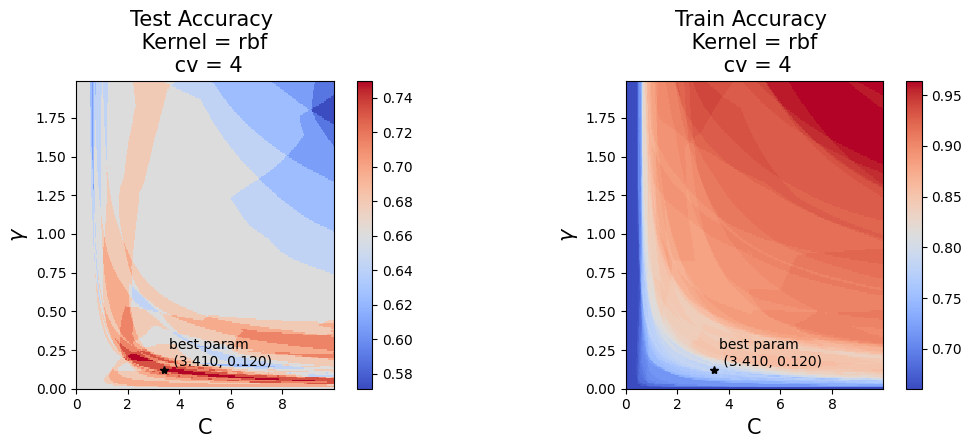

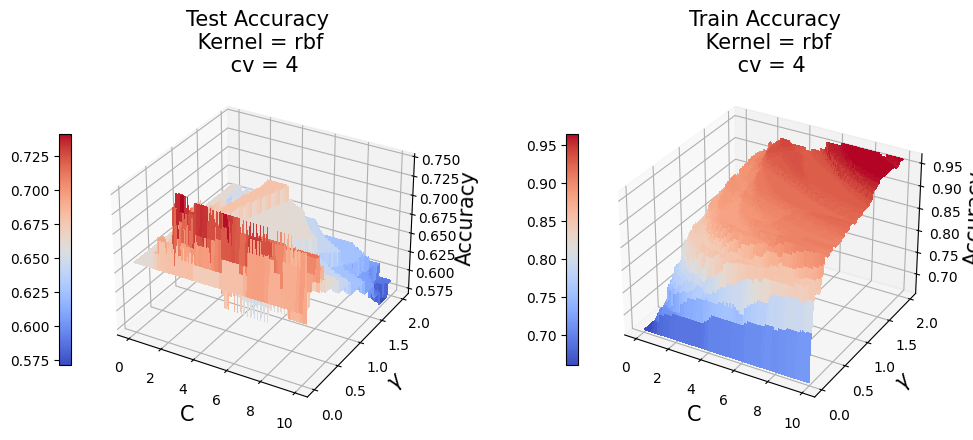

In [20]:
# cv = 4, kl = rbf, plot_surface and im_show

print('\n ########################################################################## \n')

best_score_cv4, best_hyperparams_cv4  = best_param_svm_search(X_train_sc,y_tr,
                                                              4,hyper_params,c,gamma,
                                                              './figs/im_cv4_pca_nca','./figs/surf_cv4_pca_nca',
                                                              kl ="rbf",rnd_st=1234)
# cv is optimal if |best_test_score - best_train_score| is minimum

print("Highest test score found by GridSearchCV = " + str(best_score_cv4))
print("Best hyperparameters found by GridSearchCV = " + str(best_hyperparams_cv4))

# print("BestParam test score found from surface plot = " + str(best_test_sc_cv4))
# print("BestParam train score found from surface plot = " + str(best_train_sc_cv4))
# print("|bestParam_test_sc - bestParam_train_sc| =" + str(np.abs(best_test_sc_cv4 - best_train_sc_cv4)))

thresh: 0.5000, mcc: 0.0000, AUC test-set: 0.7708
[[16  0]
 [ 9  0]]
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         9
         1.0       0.64      1.00      0.78        16

    accuracy                           0.64        25
   macro avg       0.32      0.50      0.39        25
weighted avg       0.41      0.64      0.50        25

thresh: 0.6540, mcc: 0.3787, AUC test-set: 0.7708
[[13  3]
 [ 4  5]]
              precision    recall  f1-score   support

        -1.0       0.62      0.56      0.59         9
         1.0       0.76      0.81      0.79        16

    accuracy                           0.72        25
   macro avg       0.69      0.68      0.69        25
weighted avg       0.71      0.72      0.72        25

mcc on training = 0.678
threshold on training = 0.654
 normal 
accuracy_CI_4 = [0.544 0.896]
recall_CI_4 = [0.6595 0.9655]
precision_CI_4 = [0.5984 0.931 ]
specificity_CI_4 = [0.3608 0.7503]
npv_CI_4 = [0.435

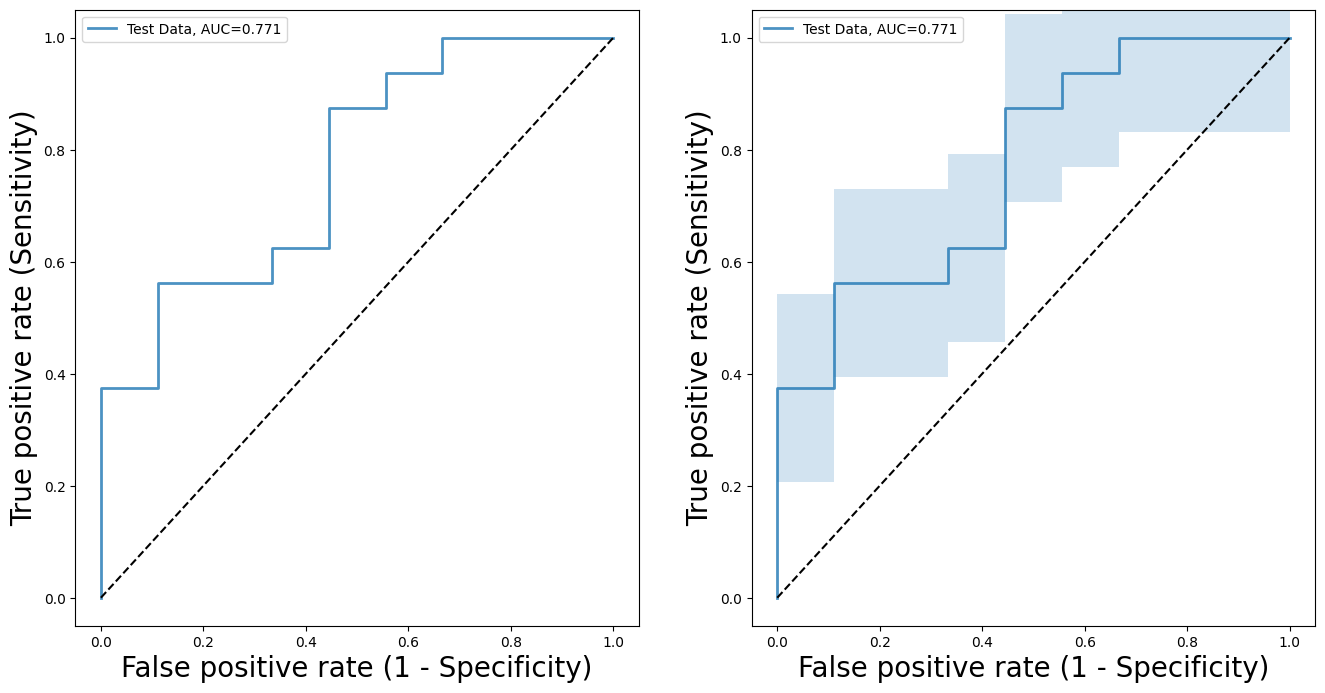

In [21]:
# cv = 4, kl = rbf

# 'MCC'
mcc_Opt_4,thr_Opt_4,y_pred_4,y_test_4,test_probs_4,cm_50_4,cm_Opt_4 = model_svm_predict(X_train_sc,y_tr,
                                                                    X_test_sc,y_tt,
                                                                    best_hyperparams_cv4,4,
                                                                    K_R_M = 'MCC',kl ="rbf")
print("mcc on training = " + str(mcc_Opt_4))
print("threshold on training = " + str(thr_Opt_4))

# confidence intervals for accuracy,recall,precision,specificity
y_pred_opt_4 = []
threshold = thr_Opt_4

y_pred_opt_4 = [1 if x>=threshold else -1 for x in test_probs_4]

print(' normal ')
bb_acc4_n = accuracy_normal(y_test_4, y_pred_opt_4)
bb_rec4_n = recall_normal(y_test_4, y_pred_opt_4)
bb_prec4_n = precision_normal(y_test_4, y_pred_opt_4)
bb_spec4_n = specificity_normal(y_test_4, y_pred_opt_4)
bb_npv4_n = npv_normal(y_test_4, y_pred_opt_4)

print("accuracy_CI_4 = " + str(bb_acc4_n))
print("recall_CI_4 = " + str(bb_rec4_n))
print("precision_CI_4 = " + str(bb_prec4_n))
print("specificity_CI_4 = " + str(bb_spec4_n))
print("npv_CI_4 = " + str(bb_npv4_n))

print(' wilson ')
bb_acc4 = accuracy_wilson(y_test_4, y_pred_opt_4)
bb_rec4 = recall_wilson(y_test_4, y_pred_opt_4)
bb_prec4 = precision_wilson(y_test_4, y_pred_opt_4)
bb_spec4 = specificity_wilson(y_test_4, y_pred_opt_4)
bb_npv4 = npv_wilson(y_test_4, y_pred_opt_4)

print("accuracy_CI_4 = " + str(bb_acc4))
print("recall_CI_4 = " + str(bb_rec4))
print("precision_CI_4 = " + str(bb_prec4))
print("specificity_CI_4 = " + str(bb_spec4))
print("npv_CI_4 = " + str(bb_npv4))

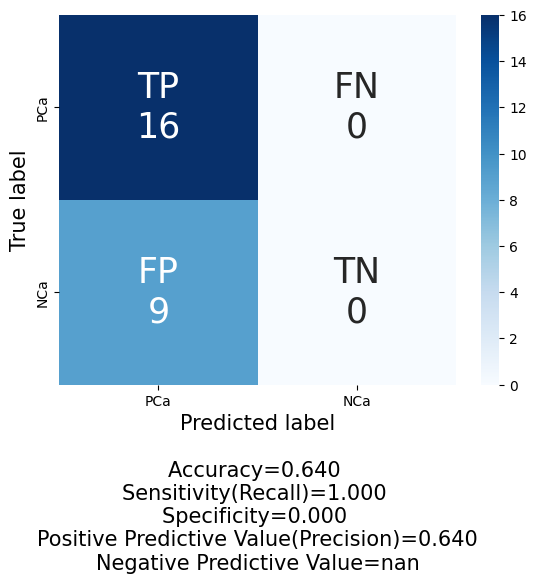

In [22]:
my_cm(cm_50_4)

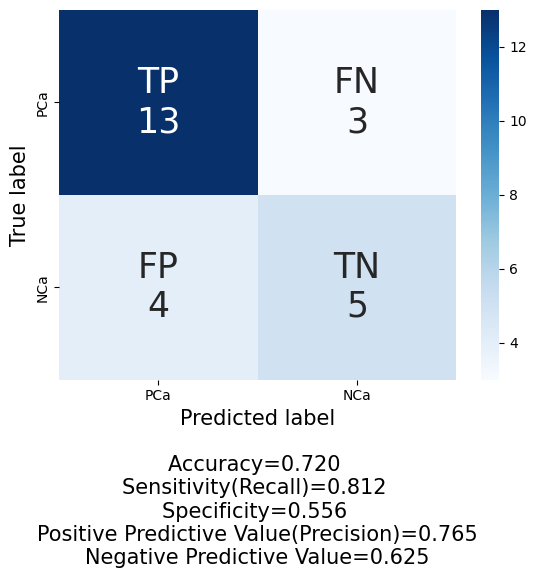

In [23]:
my_cm(cm_Opt_4)
savefig('./figs/PCa_nCa_cm')